# Sequence-to-Sequence Learning with Recurrent Neural Networks and Attention

In 2014, researchers at Google published a [paper](https://arxiv.org/abs/1409.3215) that proposed a general end-to-end approach to sequence-to-sequence learning. Sequence-to-sequence refers to a broad class of models that map one sequence to another. The proposed method uses a multilayered LSTM to map an
input sequence to a fixed-length vector, then another deep LSTM to
encode the target sequence from the vector.

## Abstract

## Table of Contents

>[Sequence-to-Sequence Learning with Recurrent Neural Networks and Attention](#scrollTo=MDGifB0xxX-y)

>>[Abstract](#scrollTo=LXBwexBIx8VU)

>>[Table of Contents](#scrollTo=nN1wYfecbN1F)

>>[Machine Translation Task](#scrollTo=crX3IQOXyH4p)

>>[Sequence-to-Sequence Model](#scrollTo=LBWhkHN50Sxi)

>>>[Seq2Seq Training](#scrollTo=7mjCVxRo1En-)

>>>[Greedy Decoding and Teacher Forcing](#scrollTo=LQJvrp3n1q6I)

>>>[Source Sentence Reversal](#scrollTo=2xsrVmmb2K3b)

>>>[Seq2Seq Limitations and Attention](#scrollTo=EaTf8vxj23Cz)

>>[Implementation](#scrollTo=93miByFL5-6A)

>>>[Import Libraries](#scrollTo=H6hRAF2897hG)

>>>[Dataset Preparation](#scrollTo=JoBgcTAw9-Jd)

>>>[Text Preprocessing](#scrollTo=3Btk0gNDDjSK)

>>>[Models Creation](#scrollTo=GKqjr6EO-EVw)

>>>>[Encoder](#scrollTo=ZQPwT9LETYa7)

>>>>[Attention](#scrollTo=eD0ho-oRTcIO)

>>>>[Decoder](#scrollTo=UTtsEs9nTa8Y)

>>>[Training](#scrollTo=LHiWjk3K-Gtw)

>>>[Inference](#scrollTo=CdqMGvnI-HoI)

>>[References](#scrollTo=hylTxLg36xaV)



## Machine Translation Task

This section introduces a new NLP task: machine translation, as well as an overview of traditional statistical machine translation systems. The motivation for using machine translation as a representative of this class of models is that machine translation is a major use-case of sequence-to-sequence models and allows the use of many intuitive examples demonstrating the difficulties encountered when tackling sequence-to-sequence problems.

Formally, machine translation is the task of translating a source sentence $x^{n}_{1} = [x_1, x_2, ..., x_n]$ into a target sentence $y^{m}_{1} = [y_1, y_2, ..., y_m]$. Thus, any type of translation system can be defined as:
<center><h4>$\hat{y}=MT(x)$</center></h4>

where $\hat{y}$ is a translation hypothesis, given a source sentence $x$.

**Traditional Statistical machine translation systems** are systems that perform translation by creating a probabilistic model for the probability $P(y|x)$, and finding the target sentence that maximizes this probability.
<center><h4>$\hat{y}=argmax_yP(y|x)$</center></h4>

Using Bayes' rule, this probability can be broken down into two components to be learnt separately:
<center><h4>$\hat{y}=argmax_yP(x|y)P(x)$</center></h4>

- $P(x|y)$ is a translation model (learnt from parallel corpora), responsible for local translations of words and small phrases. 
- $P(x)$ is a language model (learnt from mono-lingual corpora), responsible for producing correct and fluent sentences in the target language.

Thus, training a translation model boils down to learning the conditional probability $P(x|y)$ from a parallel corpus. This is achieved by further breaking down the probability into: 
<center><h4>$P(x, a|y)$</center></h4>

where $a$ is the alignment, i.e. word-level correspondences between the source and target sentences.




## Sequence-to-Sequence Model

Neural machine translation allows us to perform translation using a single neural network whose architecture is called sequence-to-sequence, and it consists of two RNNs: an encoder and a decoder. The key idea underlying these networks is that the encoder network takes an input sequence and creates a corresponding contextualized representation, often called the context. This representation is then passed to a decoder which generates a task-specific output sequence. The decoder network is essentially a recurrent neural network language model except that it is conditioned on the input sequence.

Thus, the goal of the seq2seq model is to directly estimate the conditional probability $P(y_1, y_2, ..., y_m|x_1, x_2, ..., x_n)$. It does so by first obtaining a fixed-dimensional representation $v$ of the input sequence given by the last hidden state of the encoder network, and then compute the conditional probabilities of the output sequence with a standard LSTM-LM formulation whose initial hidden state is set to the representation $v$ of the input sequence.

<center><h4>
$P(y_1, y_2, ..., y_m|x_1, x_2, ..., x_n)=\prod_{t=1}^{m}P(y_t|x, y_1, y_2, ..., y_{t-1})$
</center></h4>

In this equation, at each time-step, the model predicts the probability of the next target word given the previous target words and the source sentence. This probability is represented with a softmax over all words in the vocabulary. Therefore, this end-to-end approach of sequence-to-sequence model learns directly the probability $P(y|x)$, unlike statistical machine translation systems where the probability was broken-down into smaller components. This is an improvement because it doesn't require learning different systems and optimizing them separately.  

Encoder-decoder architectures are trained end-to-end, just as with the RNN language models. Each training example is a tuple of paired strings, a source and a target. Each string is required to end with a special end-of-sentence symbol `[EOS]`, which enables the model to define a distribution over sequences of all possible lengths. The overall scheme is outlined in the following figure.

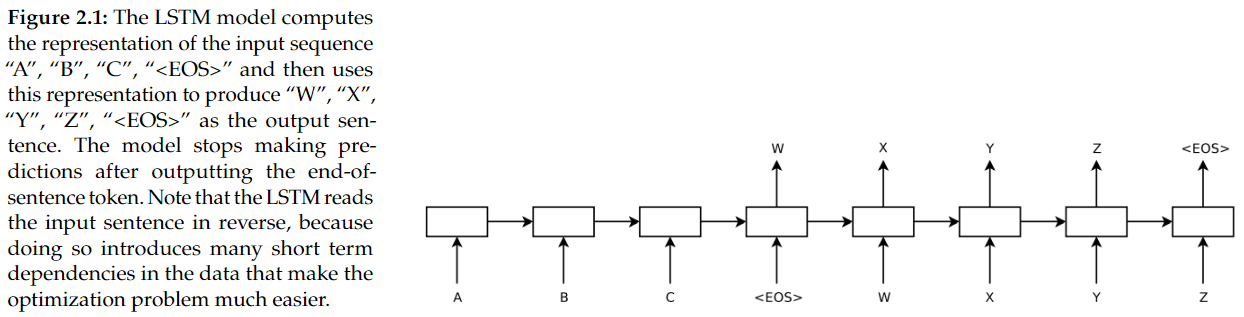

### Seq2Seq Training

Training a seq2seq model starts with computing $RNN^{(x)}(x_0, h_0)$. This generates an output vector and a hidden state vector $h_1$. Next, the output vector is ignored, and $RNN^{(x)}(x_1, h_1)$ is computed. The process is repeated until the model goes through the entirety of the input sequence. The goal is to "prime" the model's hidden state vector such that by the time the model processes all of the source sequence elements, the hidden state contains all of the information needed for another model to then sequentially generate the target sentence. 

Accordingly, the decoder $RNN^{(y)}(\bar{v}, \bar{h_n})$ is fed the final encoder hidden state vector $h_{n}$ as its initial hidden state, along with the first element of the sequence to decode. The decoder outputs a categorical distribution over the target vocabulary. We use this distribution along with the ground truth to compute the contribution of that target element to the overall loss, which is some metric appropriate for comparing distributions such as cross-entropy.

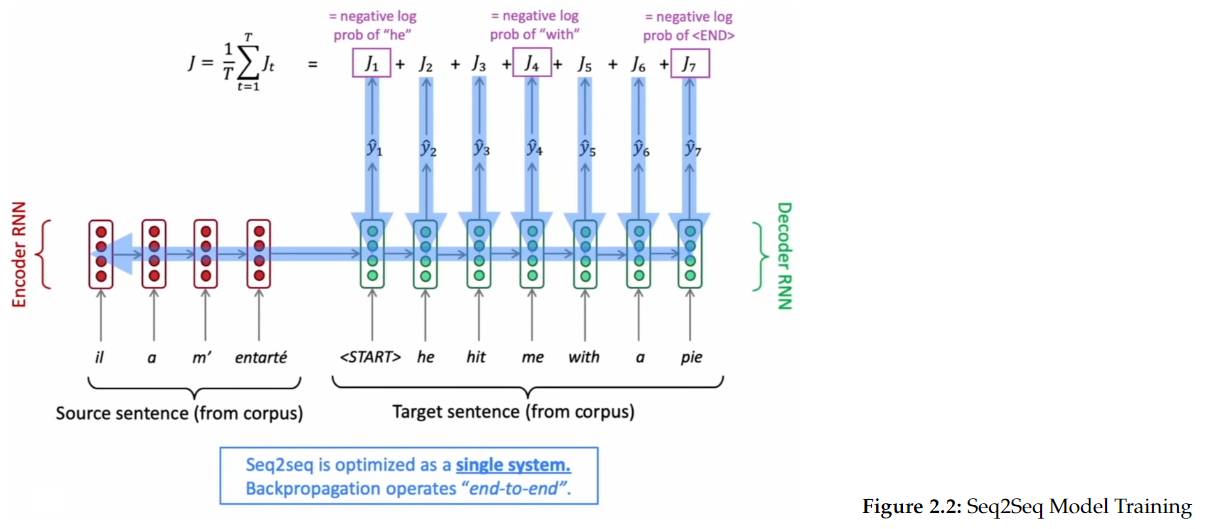

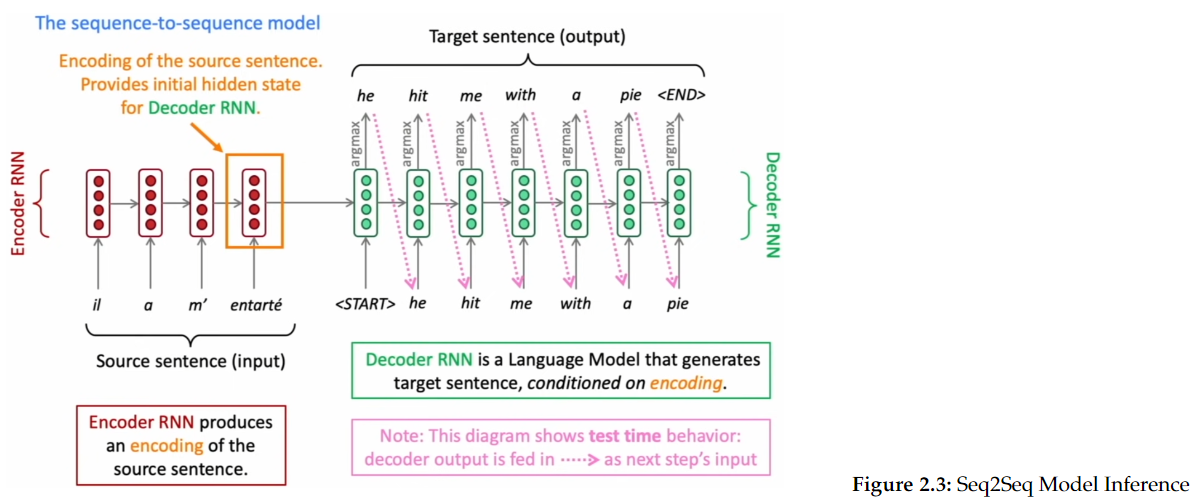

### Greedy Decoding and Teacher Forcing

As shown in the figures above, the differences between training and inference with respect to the outputs at each time step is that the decoder during inference uses its own estimated output $\hat{y_t}$ as the input for the next time step $x_{t+1}$. Thus the decoder will tend to deviate more and more from the gold target sentence as it keeps generating more tokens. In training, therefore, it is more common to use teacher forcing in the decoder. Teacher forcing means that we force the system to use the gold target token from training as the next input $x_{t+1}$, rather than allowing it to rely on the (possibly erroneous) decoder output $\hat{y_t}$. This speeds up training. This is related to the issue of greedy decoding in sequence-to-sequence models. The greediness of the decoding is due to the fact that $argmax$ is taken at each time-step. The problem is that taking the $argmax$ at a particular step is not necessarily going to produce the $argmax$ over the entire sentence. Additionally, greedy decoding has no way to undo decisions. This can be solved by doing a beam-search over several translation hypotheses, which involves exploring several target sequence trajectories simultaneously and picking the sequence with the highest likelihood. The number of trajectories to be explored is a hyperparameter referred to as the "beam width".

### Source Sentence Reversal

While the LSTM is capable of solving problems with long-term dependencies, the seq2seq paper suggested that the LSTM learns much better when the source sentences are reversed (the target sentences are not reversed). Normally, when a source sentence is concatenated with a target one, each source word is far from its corresponding target word. As a result, the problem has a large “minimal time lag”. By reversing the words in the source sentence, the average distance between corresponding words in the source and target language is unchanged. However, the first few words in the source language are now very close to the first few words in the target language, so the problem’s minimal time lag is greatly reduced. Thus, backpropagation has an easier time “establishing communication” between the two sentences, which in turn results in substantially improved overall performance, particularly on long sentences. This suggests that reversing the input sentences results in LSTMs with better memory utilization.

### Seq2Seq Limitations and Attention

**Information Bottleneck**

The simplicity of the encoder-decoder model is its clean separation of the encoder - which builds a representation of the source text - from the decoder, which uses this context to generate a target text. In the seq2seq model, this context vector is the hidden state of the last (nth) time-step $h_n$ of the source text. This final hidden state is thus acting as a bottleneck: it must represent absolutely everything about the meaning of the source text, since it's the only thing the decoder knows about the source text. The issue with this is that information at the beginning of the sentence, especially for long sentences, may not be equally well represented in the context vector. This issue is because:
- Decoder can only access the context vector (final hidden state of the encoder).
- The fixed length of the context vector.


The attention mechanism is a solution to the bottleneck problem. The main idea behind attention is that instead of producing a single hidden state for the input sequence, the encoder outputs a hidden state at each step that the decoder can access. However, using all the states at the same time would create a huge input for the decoder, so some mechanism is needed to prioritize which states to use. This is where attention comes in: it lets the decoder assign a different amount of weight, or “attention,” to each of the encoder states at every decoding time-step. 

Attention can now be formally defined as a weighted sum of a set of values: the hidden states vectors, producing a single fixed-length vector. The weights are computed according to a compatibility/similarity function between a query: the decoder's hidden state at the current step and a set of keys: all the encoder's hidden states. These weights focus on ("attend to") a particular part of the source text that is relevant for the token the decoder is currently producing. Attention thus replaces the static context vector with one that is dynamically derived anew with each decoding step and takes all of the encoder hidden states into account in its derivation.

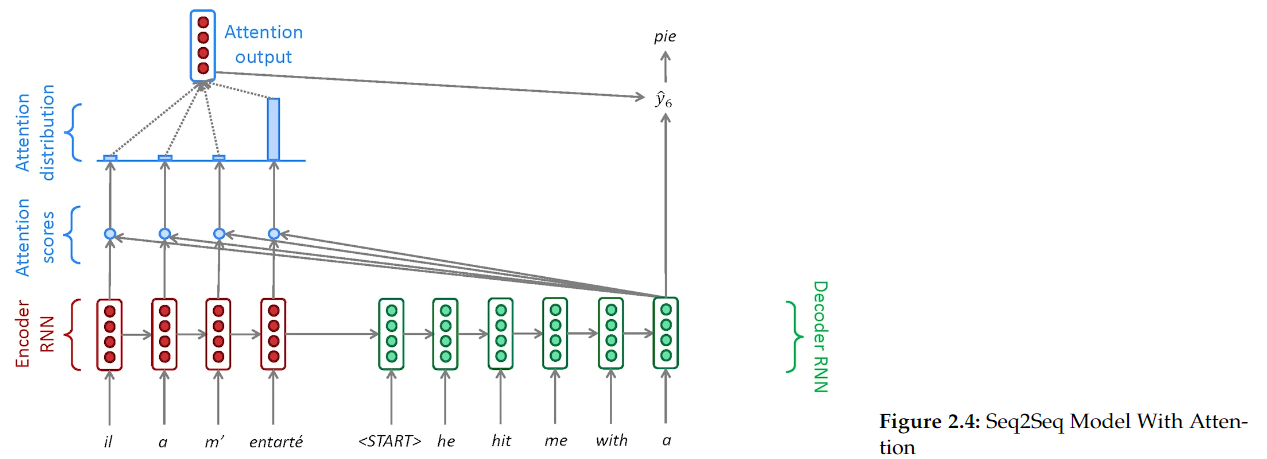

As shown in the figure above, the first to computing the attention vector is to determine how much to focus on each encoder state. In other words how relevant each encoder state is to the current decoder step. These relevance scores is computed through the following dot-product attention function:

<center><h4>
$e^{(t)} = [s^T_th_1, s^T_th_2, ..., s^T_th_T] \in \mathbb{R}^T$
</center></h4>

where 
- $h_1, h_2, ..., h_T \in \mathbb{R}^h$ are the encoder's hidden states.
- $s_t \in \mathbb{R}^h$ is the decoder's current hidden state.
- $e^{(t)}$ is the attention scores vector at the decoding time-step $t$.

Then, softmax is applied to the attention scores vector to produce an attention distribution over all the encoder's hidden states.
<center><h4>
$\alpha^{(t)} = softmax(e^{(t)}) \in \mathbb{R}^T$
</center></h4>

Finally, an attention vector can be obtained as the weighted sum of the encoder's hidden states:
<center><h4>
$a^{(t)} = \sum_{t=1}^{T} \alpha_i^{(t)}h_i \in \mathbb{R}^h$
</center></h4>

With this, we finally have a fixed-length context vector that takes into account information from the entire encoder state that is dynamically updated to reflect the needs of the decoder at each step of decoding. The attention vector is then concatenated with the decoder's hidden state to produce the output at the current time-step.

In addition to solving the bottleneck problem, attention greatly improves NMT performance. Additionally, by focusing on which input tokens are most relevant at each time-step, these attention-based models are able to learn nontrivial alignments between the words in a generated translation and those in a source sentence, despite never explicitly training an alignment system, unlike traditional SMTs. Finally, these are soft alignments as they are produced by a softmax layer.

## Implementation


### Import Libraries

In [2]:
!pip install datasets -q
!pip install "tensorflow-text==2.8.*" -q

In [3]:
from datasets import load_dataset

import numpy as np

import tensorflow as tf
import tensorflow_text as tf_text

from keras.models import Model
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, CategoryEncoding

### Dataset Preparation

In [4]:
dataset = load_dataset("Helsinki-NLP/tatoeba_mt", "eng-ita")

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
print("The dataset contains the following subsets:")
print("-" * 40)
for split in dataset.keys():
  print(f"{split} subset, consisting of {len(dataset[split])} sentence-pairs.")

The dataset contains the following subsets:
----------------------------------------
test subset, consisting of 17319 sentence-pairs.
validation subset, consisting of 472973 sentence-pairs.


In [6]:
num_training_instances = 10000
num_test_instances = 5000

# Get lists of training and testing sentences
eng_sentences_train = dataset["validation"]["sourceString"][:num_training_instances]
ita_sentences_train = dataset["validation"]["targetString"][:num_training_instances]

eng_sentences_test = dataset["test"]["sourceString"][:num_test_instances]
ita_sentences_test = dataset["test"]["targetString"][:num_test_instances]

In [7]:
print(eng_sentences_train[5])
print(ita_sentences_train[5])

1980 was the year that I was born.
Il 1980 è l'anno in cui sono nata.


### Text Preprocessing

In [8]:
def preprocess(text):

  # Lowercase the text
  text = tf.strings.lower(text)

  # Keep only letters, numbers, and select punctuation
  text = tf.strings.regex_replace(text, "[^ a-zA-Z0-9()[].,:;?!]+", " ")

  # Surround punctuation with spaces
  text = tf.strings.regex_replace(text, "([.,;:?!])", r" \0 ")

  # Strip extra spaces
  text = tf.strings.regex_replace(text, '[" "]+', " ")

  # Strip whitespace
  text = tf.strings.strip(text)

  # Return the text surronded by the START and END tags
  return tf.strings.join(["[START]", text, "[END]"], separator=" ")

In [9]:
max_vocab_size = 5000
max_seq_len = 32

eng_vectorization_layer = tf.keras.layers.TextVectorization(
    standardize=preprocess,
    max_tokens=max_vocab_size,
    output_sequence_length=max_seq_len,
    pad_to_max_tokens=True)

ita_vectorization_layer = tf.keras.layers.TextVectorization(
    standardize=preprocess,
    max_tokens=max_vocab_size,
    output_sequence_length=max_seq_len,
    pad_to_max_tokens=True)

eng_vectorization_layer.adapt(eng_sentences_train)
ita_vectorization_layer.adapt(ita_sentences_train)

In [10]:
encoder_input = eng_vectorization_layer(eng_sentences_train).numpy()
decoder_input = ita_vectorization_layer(ita_sentences_train).numpy()
target_offset_tensor = decoder_input[:][:, 1:] 

zeros = np.zeros(shape=(target_offset_tensor.shape[0], 1))
target_offset_tensor = np.concatenate((target_offset_tensor, zeros), axis=1)


print(f"source_tensor.shape = {encoder_input.shape}")
print(f"decoder_input.shape = {decoder_input.shape}")
print(f"target_offset_tensor.shape = {target_offset_tensor.shape}")

source_tensor.shape = (10000, 32)
decoder_input.shape = (10000, 32)
target_offset_tensor.shape = (10000, 32)


In [11]:
one_hot_encoding_layer = CategoryEncoding(
    num_tokens=max_vocab_size,
    output_mode="one_hot"
)

decoder_output = np.zeros(shape=(target_offset_tensor.shape + (max_vocab_size,)), dtype=bool)
for sequence_idx in range(target_offset_tensor.shape[0]):
  for word_idx in range(target_offset_tensor.shape[1]):
    decoder_output[sequence_idx, word_idx, :] = one_hot_encoding_layer(target_offset_tensor[sequence_idx, word_idx])
print(decoder_output.shape)

(10000, 32, 5000)


### Models Creation

The seq2seq process will be as follows:

Turn the source-target sentence-pair into 3 Numpy arrays, `encoder_input_sequence`, `decoder_input_sequence`, `decoder_output_sequence`.

  - `encoder_input_sequence` is a 2D array of shape (`num_instances`, `max_seq_len`) containing the integer embedding of the English sentences. 

  - `decoder_input_sequence` is a 2D array of shape (`num_instances`, `max_seq_len`) containing the integer embedding of the Italian sentences. 

  - `decoder_output_sequence` is the same as `decoder_input_sequence` but offset by one timestep.


In [12]:
embedding_dim = 64
batch_size = 64

# Encoder/Decoder Inputs
encoder_inputs = Input(shape=(max_seq_len), name="encoder_inputs")
decoder_inputs = Input(shape=(max_seq_len), name="decoder_inputs")

# Encoder/Decoder Embedding Layers
encoder_embedding = Embedding(max_seq_len, embedding_dim, name="encoder_embedding")
decoder_embedding = Embedding(max_seq_len, embedding_dim, name="decoder_embedding")

# Encoder/Decoder LSTMs
encoder_lstm = LSTM(embedding_dim, return_state=True, name="encoder_lstm")
decoder_lstm = LSTM(embedding_dim, return_state=True, return_sequences=True, name="decoder_lstm")

# Decoder's Output
decoder_dense = TimeDistributed(Dense(max_vocab_size, activation="softmax", name="decoder_dense"))

In [13]:
x = encoder_embedding(encoder_inputs)
encoder_outputs, state_h, state_c = encoder_lstm(x)
encoder_states = [state_h, state_c]

x = decoder_embedding(decoder_inputs)
x, _, _ = decoder_lstm(x, initial_state=encoder_states)
decoder_outputs = decoder_dense(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 32, 64)       2048        ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 32, 64)       2048        ['decoder_inputs[0][0]']         
                                                                                              

In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
model.fit([encoder_input, decoder_input], decoder_output,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 12s 45ms/step - loss: 3.7414 - accuracy: 0.7354 - val_loss: 1.2935 - val_accuracy: 0.7994
Epoch 2/20
125/125 [==============================] - 5s 37ms/step - loss: 1.5402 - accuracy: 0.7526 - val_loss: 1.1084 - val_accuracy: 0.7994
Epoch 3/20
125/125 [==============================] - 5s 37ms/step - loss: 1.3878 - accuracy: 0.7728 - val_loss: 1.0323 - val_accuracy: 0.8304
Epoch 4/20
125/125 [==============================] - 5s 37ms/step - loss: 1.3298 - accuracy: 0.7895 - val_loss: 0.9893 - val_accuracy: 0.8545
Epoch 5/20
125/125 [==============================] - 5s 37ms/step - loss: 1.2926 - accuracy: 0.8022 - val_loss: 0.9639 - val_accuracy: 0.8583
Epoch 6/20
125/125 [==============================] - 5s 37ms/step - loss: 1.2630 - accuracy: 0.8078 - val_loss: 0.9395 - val_accuracy: 0.8588
Epoch 7/20
125/125 [==============================] - 5s 37ms/step - loss: 1.2363 - accuracy: 0.8127 - val_loss: 0.9238 - val_accuracy: 0.866

## References

1. Sequence to Sequence Learning with Neural Networks [Paper](https://arxiv.org/abs/1409.3215)

2. Effective Approaches to Attention-based Neural Machine Translation [Paper](https://arxiv.org/abs/1508.04025v5)

3. *Dan Jurafsky and James H. Martin. [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/) (3rd ed. draft).*

4. Stanford CS224n: Natural Language Processing with Deep Learning: [Translation, Seq2Seq, Attention](https://web.stanford.edu/class/cs224n/index.html#coursework)